In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from itertools import chain
import cftime
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle, Patch
from matplotlib.offsetbox import AnchoredOffsetbox, DrawingArea
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.io.img_tiles as cimgt
import matplotlib.gridspec as gridspec
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [ ]:
data = pd.read_csv('processed data/famine_region_data.csv')

# Fig 1

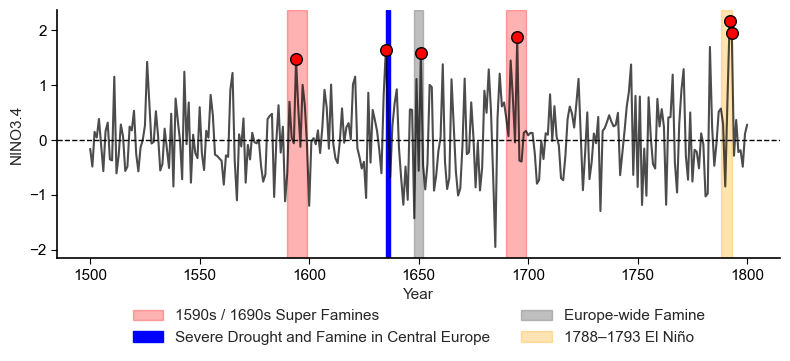

In [3]:
# ---- Set minimal classic style ----
sns.set_style("ticks")  # white background
plt.rcParams.update({
    "axes.edgecolor": "black",    # axes lines color
    "axes.linewidth": 1.2,        # axes lines width
    "xtick.direction": "out",     # ticks outward
    "ytick.direction": "out",
    "xtick.major.size": 4,        # small ticks
    "ytick.major.size": 4,
    "xtick.minor.size": 2,
    "ytick.minor.size": 2,
    "axes.spines.top": False,     # hide top spine
    "axes.spines.right": False,   # hide right spine
    "xtick.labelsize": 11,        # tick font size
    "ytick.labelsize": 11,
    "xtick.color": "black",
    "ytick.color": "black",
})

plt.figure(figsize=(8, 4))

enso_earlymodern = data.groupby("Year")["nino34"].mean().reset_index() 

# Line plot
sns.lineplot(data=enso_earlymodern, x='Year', y='nino34', color='black', linewidth=1.5, alpha=0.7)

# Highlight shaded decades
for start in [1590, 1690]:
    plt.axvspan(start, start + 9, color='red', alpha=0.3,
                label='' if start != 1590 else '1590s / 1690s Super Famines')

# Specific famines
plt.axvspan(1635, 1637, color='blue', alpha=1, label='Severe Drought and Famine in Central Europe')
plt.axvspan(1648, 1652, color='gray', alpha=0.5, label='Europe-wide Famine')
plt.axvspan(1788, 1793, color='orange', alpha=0.3, label='1788–1793 El Niño')

# Highlight top 7 Niño3.4 values, excluding 4th largest
top7 = enso_earlymodern.nlargest(7, 'nino34')
top7 = top7.drop(top7.index[3])
plt.scatter(top7['Year'], top7['nino34'], color='red', edgecolor='black', s=70, zorder=5)

# Axis labels
plt.xlabel('Year', fontsize=11)
plt.ylabel('NINO3.4', fontsize=11)

# Horizontal line at 0
plt.axhline(y=0.0, color='black', linestyle='--', linewidth=1)

# Legend below the plot
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    frameon=False,
    prop={"size": 11, "weight": "normal"}
)

# Only left and bottom spines visible
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Force tick labels to normal weight (unbold)
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontweight("normal")

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig('figures/plots/nino34_timeseries_shaded.pdf', dpi=300, bbox_inches='tight')
plt.show()


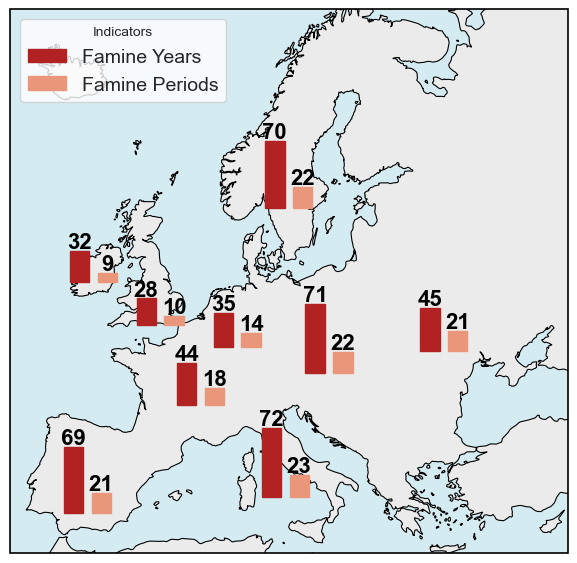

In [4]:
# Replace this with your actual DataFrame
region_stats = data.groupby('Region').agg(
    famine_years=('Famine', 'sum'),
    famine_periods=('Famine_start', 'sum')
).reset_index()

region_centers = {
    'France': (5, 48),
    'Central Europe': (18, 50),
    'Italy': (13, 42),
    'Spain': (-4, 40),
    'Nordic Countries': (15, 61),
    'Great Britain': (-0, 53),
    'Ireland': (-8.25, 55),
    'Russia/Ukraine': (30, 50),
    'Low Countries': (8.5, 52),
}

max_val = max(region_stats['famine_years'].max(), region_stats['famine_periods'].max())
scale = 50 / max_val

plt.figure(figsize=(6, 6))
proj = ccrs.LambertConformal(central_longitude=10, central_latitude=50, standard_parallels=(45, 55))
ax = plt.axes(projection=proj)
ax.set_extent([-10, 35, 36, 70], crs=ccrs.PlateCarree())

# Basemap
ax.coastlines(linewidth=0.8)
ax.add_feature(cfeature.LAND, facecolor='lightgray',alpha=0.45)  # gray land
ax.add_feature(cfeature.OCEAN, facecolor="lightblue", zorder=0, alpha=0.5)

# # Draw countries in gray
# shapename = 'admin_0_countries'
# countries_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)
# for country in shpreader.Reader(countries_shp).records():
#     ax.add_geometries([country.geometry], ccrs.PlateCarree(),
#                       facecolor="#ebe8e8",
#                       edgecolor='black', linewidth=0.5, alpha=0.7, zorder=1)

# Add bars
for _, row in region_stats.iterrows():
    region = row['Region']
    if region not in region_centers:
        continue
    x, y = region_centers[region]
    val1, val2 = row['famine_years'], row['famine_periods']
    h1, h2 = val1 * scale, val2 * scale

    da = DrawingArea(45, 60, 0, 0)
    da.add_artist(Rectangle((0, 5), 14, h1, color='firebrick'))
    da.add_artist(Rectangle((20, 5), 14, h2, color='darksalmon'))

    txt1 = plt.Text(7, h1 + 7, str(int(val1)), ha='center', fontsize=16, fontweight='bold', color='black')
    #txt1.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])
    da.add_artist(txt1)

    txt2 = plt.Text(27, h2 + 7, str(int(val2)), ha='center', fontsize=16, fontweight='bold', color='black')
    #txt2.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])
    da.add_artist(txt2)

    ab = AnchoredOffsetbox(loc='center', child=da, frameon=False,
                           bbox_to_anchor=(x, y),
                           bbox_transform=ccrs.PlateCarree()._as_mpl_transform(ax), pad=0)
    ax.add_artist(ab)

# Legend for bars
bar_handles = [
    Patch(color='firebrick', label='Famine Years'),
    Patch(color='darksalmon', label='Famine Periods'),
]
ax.legend(handles=bar_handles, loc='upper left', fontsize=14, title='Indicators')


plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.size': 14,
    'font.weight': 'normal'
})


plt.tight_layout()
plt.savefig('figures/plots/famine_map_gray.pdf', dpi=300, bbox_inches='tight')
plt.show()


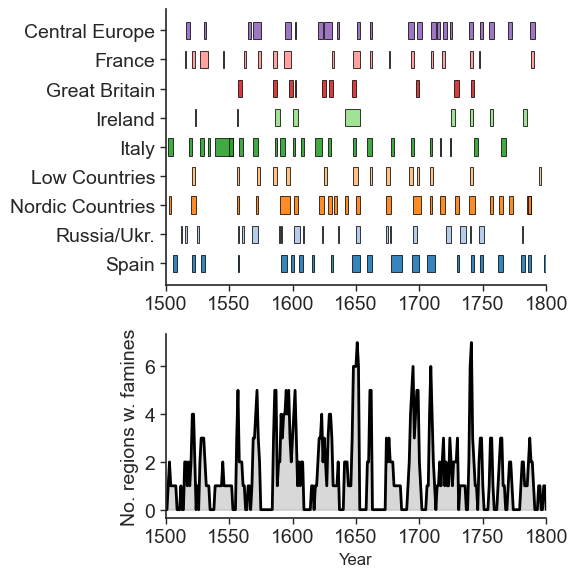

In [5]:

sns.set_style("ticks")
# --- Prepare data ---
data = data.sort_values(["Region", "Year"])

famine_periods = []
for region, group in data.groupby("Region"):
    group = group.sort_values("Year")
    active_starts = []  # can hold multiple simultaneous famine starts
    for _, row in group.iterrows():
        if row["Famine_start"] == 1:
            # push this start year onto the stack
            active_starts.append(row["Year"])

        if row["Famine"] == 0 and active_starts:
            # close all active famines at this end year
            for start_year in active_starts:
                famine_periods.append((region, start_year, row["Year"]))
            active_starts = []
        # special case: still active famines at the very last year
        if row["Year"] == group["Year"].max() and active_starts:
            for start_year in active_starts:
                famine_periods.append((region, start_year, row["Year"] + 1))
            active_starts = []

famine_plotdf = pd.DataFrame(famine_periods, columns=["Region", "Start", "End"])
all_years = pd.Series(range(data["Year"].min(), data["Year"].max() + 1), name="Year")
yearly_famine_counts = (
    data[data["Famine"] == 1]
    .groupby("Year")
    .size()
    .reindex(all_years, fill_value=0)
    .reset_index(name="Num_Famines")
)

# --- Plotting ---
region_order = sorted(data["Region"].unique(), reverse=True)
region_to_y = {region: i for i, region in enumerate(region_order)}

fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 2])
#gs.update(hspace=0.15)

# --- Top subplot (famine periods) ---
ax1 = fig.add_subplot(gs[0])
colors = sns.color_palette("tab20", len(region_order))
region_colors = {region: colors[i] for i, region in enumerate(region_order)}

for _, row in famine_plotdf.iterrows():
    ax1.barh(
        y=region_to_y[row["Region"]],
        width=row["End"] - row["Start"],
        left=row["Start"],
        height=0.6,
        color=region_colors[row["Region"]],
        edgecolor="black",
        linewidth=0.6,
        alpha=0.9
    )

region_labels = [r if r != "Russia/Ukraine" else "Russia/Ukr." for r in region_order]
ax1.set_yticks(list(region_to_y.values()))
ax1.set_yticklabels(region_labels)
ax1.grid(False)  # no gridlines for clean look
ax1.set_xlim(data["Year"].min(), data["Year"].max())
ax1.tick_params(axis="x", which="both", length=4, width=1, direction="out")
ax1.tick_params(axis="y", which="both", length=4, width=1, direction="out")
ax1.tick_params(labelsize=14)

# --- Bottom subplot (number of famines) ---
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.plot(yearly_famine_counts["Year"], yearly_famine_counts["Num_Famines"],
         color="black", linewidth=2)
ax2.fill_between(yearly_famine_counts["Year"], yearly_famine_counts["Num_Famines"],
                 color="gray", alpha=0.3)
ax2.set_ylabel("No. regions w. famines", fontsize=14)
ax2.set_xlabel("Year", fontsize=12)
ax2.set_yticks(range(0, yearly_famine_counts["Num_Famines"].max() + 1, 2))
ax2.grid(False)
ax2.tick_params(axis="x", which="both", length=4, width=1, direction="out")
ax2.tick_params(axis="y", which="both", length=4, width=1, direction="out")
ax2.tick_params(labelsize=14)

# --- Spines: only left & bottom ---
for ax in [ax1, ax2]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(1.2)
    ax.spines["left"].set_linewidth(1.2)

plt.tight_layout()
plt.savefig("figures/plots/famine_timeline.pdf", dpi=300, bbox_inches="tight")
plt.show()


# FIg 2

C:\Users\emile\AppData\Local\Temp\ipykernel_25068\2111332890.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


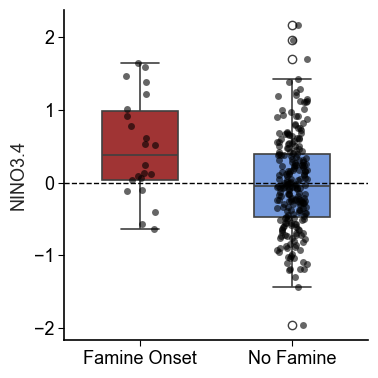

In [6]:

sns.set_style("ticks")
plt.rcParams.update({
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.major.size": 4,
    "ytick.major.size": 4,
    "xtick.minor.size": 2,
    "ytick.minor.size": 2,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "xtick.color": "black",
    "ytick.color": "black",
})

# Identify famine onset years for Central region
central_data = data[data['Region'] == 'Central Europe'].copy()
central_data = central_data.sort_values(['Region', 'Year'])

central_data['Famine_onset'] = (central_data['Famine'] > 0) & (
    central_data['Famine'].shift(1, fill_value=0) == 0
)

# Prepare dataset for plotting
plot_df = pd.concat([
    pd.DataFrame({
        'NINO3.4': central_data.loc[central_data['Famine_onset'], 'nino34'],
        'Group': 'Famine Onset'
    }),
    pd.DataFrame({
        'NINO3.4': central_data.loc[central_data['Famine'] == 0, 'nino34'],
        'Group': 'No Famine'
    })
], ignore_index=True)

# ---- Plot ----
plt.figure(figsize=(4, 4))

sns.boxplot(
    data=plot_df,
    x='Group',
    y='NINO3.4',
    palette=['firebrick', 'cornflowerblue'],
    width=0.5,
    linewidth=1.2
)
sns.stripplot(
    data=plot_df,
    x='Group',
    y='NINO3.4',
    color='black',
    alpha=0.6,
    jitter=True
)

# Reference line
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Labels
plt.ylabel('NINO3.4', fontsize=13)
plt.xlabel('', fontsize=13)

# Only left and bottom spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Force tick labels to normal weight
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontweight("normal")

plt.tight_layout()
plt.savefig('figures/plots/nino34_central_box.pdf', dpi=300, bbox_inches='tight')


# Fig 4

In [7]:
# Subset famine years
famine_years = data[data['Famine'] > 0]

# Group by Region and Famine_dur, compute mean nino34
famine_summary = famine_years.groupby(['Region', 'Famine_dur2']).agg(
    mean_nino34=('nino34', 'mean'),
    count_years=('Year', 'count')
).reset_index()

# Exclude famines longer than 12 years
fit_data = famine_summary[famine_summary['Famine_dur2'] <= 12]

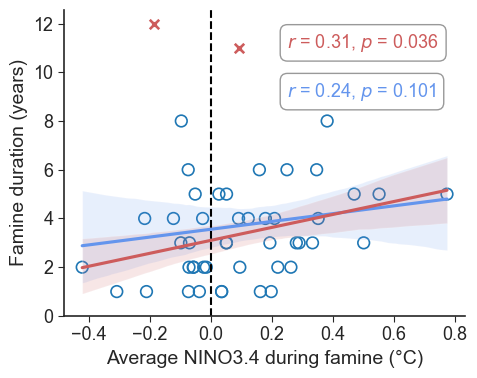

In [8]:
# ---- Classic style (ggplot theme_classic) ----
sns.set_style("ticks")
plt.figure(figsize=(5, 4))

# --- Select n longest famines ---
n_longest = 2
longest_idx = fit_data['Famine_dur2'].nlargest(n_longest).index
longest_rows = fit_data.loc[longest_idx]

# Scatter all data (blue hollow circles)
sns.scatterplot(
    data=fit_data.drop(longest_idx),
    x='mean_nino34',
    y='Famine_dur2',
    s=70,
    facecolors="none",
    edgecolor="tab:blue",
    linewidth=1.2
)

# Highlight longest famines (red crosses)
sns.scatterplot(
    data=longest_rows,
    x='mean_nino34',
    y='Famine_dur2',
    s=120,
    marker="X",   # cross marker
    color="indianred",
    linewidth=2,
)

# --- All famines regression line ---
r_all, p_all = spearmanr(fit_data['mean_nino34'], fit_data['Famine_dur2'])
sns.regplot(
    data=fit_data,
    x='mean_nino34',
    y='Famine_dur2',
    scatter=False,
    color='cornflowerblue',
    label="All famines"
)

# --- Excluding n longest famines regression line ---
fit_data_excl = fit_data.drop(longest_idx)
r_excl, p_excl = spearmanr(fit_data_excl['mean_nino34'], fit_data_excl['Famine_dur2'])
sns.regplot(
    data=fit_data_excl,
    x='mean_nino34',
    y='Famine_dur2',
    scatter=False,
    color='indianred',
    label=f"Excl. {n_longest} longest famines"
)

# Axis
ax = plt.gca()

# Annotations
plt.text(
    x=0.25, y=9,
    s=fr"$r$ = {r_all:.2f}, $p$ = {p_all:.3f}",
    fontsize=13,
    color='cornflowerblue',
    bbox=dict(boxstyle="round,pad=0.4", facecolor="white", edgecolor="gray", alpha=0.8),
    horizontalalignment='left'
)

plt.text(
    x=0.25, y=11,
    s=fr"$r$ = {r_excl:.2f}, $p$ = {p_excl:.3f}",
    fontsize=13,
    color='indianred',
    bbox=dict(boxstyle="round,pad=0.4", facecolor="white", edgecolor="gray", alpha=0.8),
    horizontalalignment='left'
)

# Labels
plt.xlabel('Average NINO3.4 during famine (°C)', fontsize=14)
plt.ylabel('Famine duration (years)', fontsize=14)

# Only left + bottom spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Force tick labels normal weight
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontweight("normal")

# Reference line at zero
plt.axvline(0, linestyle='dashed', color="black")

# Y-axis ticks step = 2
max_y = np.ceil(fit_data['Famine_dur2'].max())
yticks = np.arange(0, max_y + 1, 2)
ax.set_yticks(yticks)

plt.tight_layout()
plt.savefig('figures/plots/famine_duration_scatter.pdf', dpi=300, bbox_inches='tight')
plt.show()


C:\Users\emile\AppData\Local\Temp\ipykernel_25068\441260393.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = famine_summary.groupby('dur_bin')['mean_nino34'].mean()


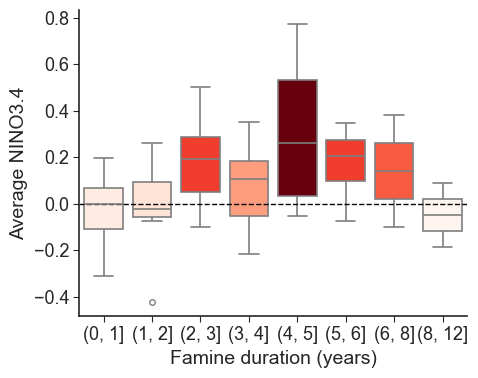

In [9]:
# Bin famine durations
famine_summary['dur_bin'] = pd.cut(
    famine_summary['Famine_dur2'],
    bins=[0, 1,2,3,4,5,6,8,12]
)

# Compute mean Niño3.4 per bin
bin_means = famine_summary.groupby('dur_bin')['mean_nino34'].mean()
norm = plt.Normalize(bin_means.min(), bin_means.max())
cmap = plt.cm.Reds  # red colormap

# ---- Classic style (ggplot theme_classic) ----
sns.set_style("ticks")

plt.figure(figsize=(5, 4))

# Boxplot with light gray as base color
ax = sns.boxplot(
    data=famine_summary,
    x='dur_bin',
    y='mean_nino34',
    color='lightgray',
    linewidth=1.2,
    fliersize=4
)

# Recolor each box according to its bin mean
for i, patch in enumerate(ax.patches[:len(bin_means)]):
    bin_label = famine_summary['dur_bin'].cat.categories[i]
    patch.set_facecolor(cmap(norm(bin_means[bin_label])))

# Horizontal reference line at 0
plt.axhline(y=0.0, color='black', linestyle='--', linewidth=1)

# Labels
plt.xlabel("Famine duration (years)", fontsize=14)
plt.ylabel("Average NINO3.4", fontsize=14)

# Only left and bottom spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# Force tick labels to normal weight
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontweight("normal")

plt.tight_layout()
plt.savefig('figures/plots/famine_duration_boxplot.pdf', dpi=300, bbox_inches='tight')
plt.show()
